In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, accuracy_score, f1_score, roc_curve, confusion_matrix

plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 16
sns.set_context('paper', font_scale=1.4)
pd.set_option('display.max_columns', None)

sns.set()
%matplotlib inline

In [101]:
test_df = pd.read_csv('data/UNSW_NB15_testing-set.csv', index_col=0)
train_df = pd.read_csv('data/UNSW_NB15_training-set.csv', index_col=0)
df_features = pd.read_csv('data/UNSW_NB15_features.csv', encoding='cp1252', index_col=0)

# ujednolicenie nazw pomiędzy ramkami danych
df_features.Name = list(map(lambda x : x.lower(), df_features.Name))
df_features.loc[:, 'Type '] = list(map(lambda x : x.lower(), df_features.loc[:, 'Type ']))
df_features.loc[df_features.Name == 'ct_src_ ltm', 'Name'] = 'ct_src_ltm'
df_features.loc[df_features.Name == 'res_bdy_len', 'Name'] = 'response_body_len'
df_features.loc[df_features.Name == 'smeansz', 'Name'] = 'smean'
df_features.loc[df_features.Name == 'dmeansz', 'Name'] = 'dmean'
df_features.loc[df_features.Name == 'sintpkt', 'Name'] = 'sinpkt'
df_features.loc[df_features.Name == 'dintpkt', 'Name'] = 'dinpkt'

In [103]:
val_df, test_df = train_test_split(test_df, random_state=710, test_size=0.3)

In [104]:
X_train = train_df.drop(columns=['label', 'attack_cat'])
y_train = train_df['label']

X_val = val_df.drop(columns=['label', 'attack_cat'])
y_val = val_df['label']

X_test = test_df.drop(columns=['label', 'attack_cat'])
y_test = test_df['label']

In [105]:
numeric_columns = X_train.select_dtypes('number').columns
categorical_columns = X_train.select_dtypes('object').columns

In [106]:
def statistics_classification(y, y_pred, y_pred_proba):
    
    # plot roc curve
    fpr, tpr, _ = roc_curve(y,  y_pred_proba)
    plt.plot(fpr,tpr)
    plt.title('ROC curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    # plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.title('Confusion matrix')
    plt.show()

    # display metrics
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print(f'{accuracy=}')
    print(f'{recall=}')
    print(f'{f1=}')

In [107]:
# ta klasa nie jest używana, ale w paru przypadkach może być wygodniejsza do użycia niż 
# ColumnSelectorTransformer, więc póki co ją zostawiam
class ColumnDropperTransformer():
    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        return X.drop(columns=self.columns)

    def fit(self, X, y=None):
        return self

class ColumnSelectorTransformer():
    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        return X[self.columns]

    def fit(self, X, y=None):
        return self

In [108]:
numeric_transformer = Pipeline(
                        steps=[
                            # nie ma u nas braków danych, ale można zastanowić się jak byśmy do
                            # nich podeszli, gdyby jednak jakieś były
                            # ('imputer', SimpleImputer(strategy="constant", fill_value=0)),
                            ("scaler", StandardScaler())
                        ]
                      )

# w kategorycznych też można pomyśleć co jeśli byłby null
categorical_transformer = OneHotEncoder(drop='first')

def create_column_transformer(columns_to_use):
    numeric_columns_to_use = np.intersect1d(columns_to_use, numeric_columns)
    categorical_columns_to_use = np.intersect1d(columns_to_use, categorical_columns)
    
    return ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_columns_to_use),
            ("cat", categorical_transformer, categorical_columns_to_use),
        ]
    )

In [109]:
columns_to_use = ['ct_dst_sport_ltm', 'sttl', 'dload', 'ct_state_ttl', 'dmean']

In [111]:
preprocessor = Pipeline(
    steps=[
        ("column_selector", ColumnSelectorTransformer(columns=columns_to_use)),
        ("column_transformer", create_column_transformer(columns_to_use))
    ]
)

rf_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=710))
    ]
)

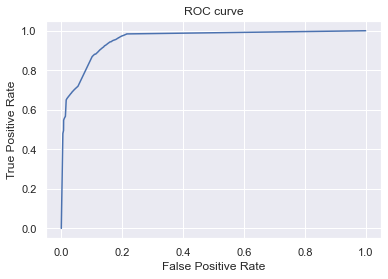

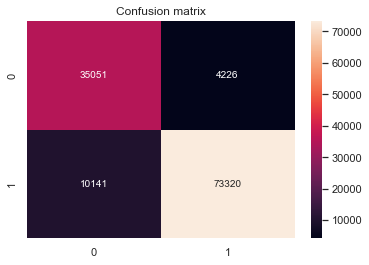

accuracy=0.8829457869608435
recall=0.8784941469668468
f1=0.910767854813766


In [112]:
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_val)
y_pred_proba = rf_clf.predict_proba(X_val)[::, 1]

statistics_classification(y_val, y_pred, y_pred_proba)